In [ ]:
import tensorflow as tf
import numpy as np
import time
import pandas as pd
import keras as K
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Flatten, Dropout, Conv2D, ReLU, DepthwiseConv2D, add, Activation, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, MobileNetV3Small, ResNet50, VGG16, InceptionResNetV2, MobileNet, MobileNetV3Large
from tensorflow.keras.layers import Lambda
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal, Constant
import os

tf.random.set_seed(64)

In [ ]:
# CIFAR-100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()


In [ ]:
models = {
     'MobileNet': {
        'input_shape': (224, 224, 3),
        'class': MobileNet,
        'preprocess_input': tf.keras.applications.mobilenet.preprocess_input
    },

    'MobileNetV2': {
        'input_shape': (224, 224, 3),
        'class': MobileNetV2,
        'preprocess_input': tf.keras.applications.mobilenet_v2.preprocess_input
    }

    # 'MobileNetV3Large': {
    #     'input_shape': (224, 224, 3),
    #     'class': MobileNetV3Large,
    #     'preprocess_input': tf.keras.applications.mobilenet_v3.preprocess_input
    # }

    # # 'MobileNetV3Small': {
    # #     'input_shape': (224, 224, 3),
    # #     'class': MobileNetV3Small,
    # #     'preprocess_input': tf.keras.applications.mobilenet_v3.preprocess_input
    # # }

    # 'EfficientNetB0': {
    #     'input_shape': (224, 224, 3),
    #     'class': EfficientNetB0,
    #     'preprocess_input': tf.keras.applications.efficientnet.preprocess_input
    # },

    # 'ResNet50': {
    #     'input_shape': (224, 224, 3),
    #     'class': ResNet50,
    #     'preprocess_input': tf.keras.applications.resnet50.preprocess_input
    # }

}

In [ ]:
def preprocess_data(x, y, model_name):
    preprocess_fn = models[model_name]['preprocess_input']
    x = preprocess_fn(x)
    y = to_categorical(y, 100)
    return x, y

In [ ]:
print(x_train.shape)

(50000, 32, 32, 3)


In [ ]:
def build_model(modelName):

  model_info = models[modelName]
  # Extract the model class and target shape from the dictionary
  base_model_class = model_info['class']
  target_shape = model_info['input_shape']

    # Create base model
  base_model = base_model_class(input_shape=target_shape, include_top=False, weights='imagenet')
  base_model.trainable = False
  inputs = K.Input(shape=(32,32,3))
  resized_input = Lambda(lambda x: tf.image.resize(x, target_shape[:2]))(inputs)
  x = base_model(resized_input, training= False)
  x = GlobalAveragePooling2D()(x)
  x = Dense(500, activation='relu')(x)
  x = Dropout(0.3)(x)
  outputs = Dense(100, activation='softmax')(x)
  model = K.Model(inputs, outputs)
  return model

In [ ]:
# def build_model_Zulfi():
#     model = Sequential()

#     model.add(Conv2D(256,(3,3),padding='same',input_shape=(32,32,3)))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv2D(256,(3,3),padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPool2D(pool_size=(2,2)))
#     model.add(Dropout(0.2))

#     model.add(Conv2D(512,(3,3),padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv2D(512,(3,3),padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPool2D(pool_size=(2,2)))
#     model.add(Dropout(0.2))

#     model.add(Conv2D(512,(3,3),padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv2D(512,(3,3),padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPool2D(pool_size=(2,2)))
#     model.add(Dropout(0.2))

#     model.add(Conv2D(512,(3,3),padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv2D(512,(3,3),padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPool2D(pool_size=(2,2)))
#     model.add(Dropout(0.2))

#     model.add(Flatten())
#     model.add(Dense(1024))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization(momentum=0.95,
#         epsilon=0.005,
#         beta_initializer=RandomNormal(mean=0.0, stddev=0.05),
#         gamma_initializer=Constant(value=0.9)))
#     model.add(Dense(100,activation='softmax'))

#     return model

In [ ]:
def quantize_model_dynamic(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    return converter.convert()

def quantize_model_float16(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    return converter.convert()

def quantize_model_int8(model, x_sample):
    def representative_data_gen():
        for i in range(len(x_sample)):
            yield [x_sample[i:i+1].astype(np.float32)]

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8
    return converter.convert()


In [ ]:
def evaluate_tflite_model(tflite_model, x_test, y_test):
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']
    input_dtype = input_details[0]['dtype']

    correct = 0
    total_time = 0

    for i in range(len(x_test)):
        input_data = x_test[i:i+1]

        # 🛠️ Cast input to correct dtype
        if input_dtype == np.uint8:
            # input_data = (input_data * 255).astype(np.uint8)
            scale, zero_point = input_details[0]['quantization']
            input_data = (input_data / scale + zero_point).astype(np.uint8)
        else:
            input_data = input_data.astype(np.float32)

        label = np.argmax(y_test[i])

        start_time = time.time()
        interpreter.set_tensor(input_index, input_data)
        interpreter.invoke()
        pred = interpreter.get_tensor(output_index)
        end_time = time.time()

        if np.argmax(pred) == label:
            correct += 1
        total_time += (end_time - start_time)

    accuracy = correct / len(x_test)
    avg_inference_time = total_time / len(x_test)
    return accuracy, avg_inference_time


In [ ]:
def plot_training_histories(histories):
    plt.figure(figsize=(15, 10))

    # Plot training accuracy
    plt.subplot(2, 2, 1)
    for model_name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{model_name} Train')
    plt.title('Model Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Plot validation accuracy
    plt.subplot(2, 2, 2)
    for model_name, history in histories.items():
        plt.plot(history.history['val_accuracy'], label=f'{model_name} Val')
    plt.title('Model Test Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Plot training loss
    plt.subplot(2, 2, 3)
    for model_name, history in histories.items():
        plt.plot(history.history['loss'], label=f'{model_name} Train')
    plt.title('Model Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot validation loss
    plt.subplot(2, 2, 4)
    for model_name, history in histories.items():
        plt.plot(history.history['val_loss'], label=f'{model_name} Val')
    plt.title('Model Test Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig('training_history_comparison.png')
    plt.show()

In [ ]:
def train_all_models(x_train, y_train, x_test, y_test, epochs=5, batch_size=300):
    results = []
    histories = {}

    for model_name in models.keys():
        print(f"\n{'='*50}")
        print(f"Training {model_name}")
        print(f"{'='*50}")

        # Preprocess data
        x_train_pp, y_train_pp = preprocess_data(x_train, y_train, model_name)
        x_test_pp, y_test_pp = preprocess_data(x_test, y_test, model_name)

        # Build and compile model
        model = build_model(model_name)
        model.compile(
            optimizer=Adam(learning_rate=0.0005),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Train model
        start_time = time.time()
        history = model.fit(
            x_train_pp, y_train_pp,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test_pp, y_test_pp),
            verbose=1
        )
        end_time = time.time()
        training_time = end_time - start_time

        histories[model_name] = history

        train_acc = history.history['accuracy'][-1]
        train_loss = history.history['loss'][-1]

        # Evaluate model
        loss, acc = model.evaluate(x_test_pp, y_test_pp, verbose=0)

        # Inference time per sample (on 100 samples)
        start_inf = time.time()
        _ = model.predict(x_test_pp[:100], verbose=0)
        end_inf = time.time()
        inference_time_per_sample = (end_inf - start_inf) / 100

        # Save temporarily to get model size
        model_path = f'{model_name}_temp.h5'
        model.save(model_path)
        model_size = os.path.getsize(model_path) / (1024 * 1024)  # in MB
        os.remove(model_path)

        quant_dynamic = quantize_model_dynamic(model)
        quant_fp16 = quantize_model_float16(model)
        quant_int8 = quantize_model_int8(model, x_test_pp[:100])

        acc_dynamic, time_dynamic = evaluate_tflite_model(quant_dynamic, x_test_pp, y_test_pp)
        acc_fp16, time_fp16 = evaluate_tflite_model(quant_fp16, x_test_pp, y_test_pp)
        acc_int8, time_int8 = evaluate_tflite_model(quant_int8, x_test_pp, y_test_pp)

        results.append({
            'Model': model_name,
            'Train Accuracy': train_acc,
            'Train Loss': train_loss,
            'Test Accuracy': acc,
            'Test Loss': loss,
            'Parameters': model.count_params(),
            'Training Time (s)': round(training_time, 2),
            'Inference Time (s/sample)': round(inference_time_per_sample, 4),
            'Model Size (MB)': round(model_size, 2),

            'Original Accuracy (%)': round(acc * 100, 2),
            'Original Loss (%)': round(loss * 100, 2),

            'Dynamic Range Accuracy (%)': round(acc_dynamic * 100, 2),
            'Float16 Accuracy (%)': round(acc_fp16 * 100, 2),
            'INT8 Accuracy (%)': round(acc_int8 * 100, 2),

            'Dynamic Inference Time (ms)': round(time_dynamic * 1000, 2),
            'Float16 Inference Time (ms)': round(time_fp16 * 1000, 2),
            'INT8 Inference Time (ms)': round(time_int8 * 1000, 2),

            'Dynamic Model Size (MB)': round(len(quant_dynamic) / (1024 * 1024), 2),
            'Float16 Model Size (MB)': round(len(quant_fp16) / (1024 * 1024), 2),
            'INT8 Model Size (MB)': round(len(quant_int8) / (1024 * 1024), 2)
        })

    results_df = pd.DataFrame(results)
    print("\nTraining Results:")
    print(results_df.to_string(index=False))

    # Optionally save results
    results_df.to_csv('model_comparison_results.csv', index=False)
    return results_df, histories


Training MobileNet
Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 51s 278ms/step - accuracy: 0.2202 - loss: 3.4346 - val_accuracy: 0.5779 - val_loss: 1.5676
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 74s 241ms/step - accuracy: 0.5494 - loss: 1.6324 - val_accuracy: 0.6302 - val_loss: 1.3225
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 46s 271ms/step - accuracy: 0.6156 - loss: 1.3645 - val_accuracy: 0.6499 - val_loss: 1.2342
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 81s 266ms/step - accuracy: 0.6500 - loss: 1.2283 - val_accuracy: 0.6624 - val_loss: 1.1733
Epoch 5/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 81s 261ms/step - accuracy: 0.6746 - loss: 1.1249 - val_accuracy: 0.6740 - val_loss: 1.1364


Saved artifact at '/tmp/tmpil3lxvic'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_393')
Output Type:
  TensorSpec(shape=(None, 100), dtype=tf.float32, name=None)
Captures:
  136519883737808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136519883738768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136519883742032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136519883736656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136519883737424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136519883742800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136519883736848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136519710339152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136519883740688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136519883738192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1365197103

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



Training MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 76s 372ms/step - accuracy: 0.2442 - loss: 3.3461 - val_accuracy: 0.5672 - val_loss: 1.5713
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 53s 255ms/step - accuracy: 0.5555 - loss: 1.6202 - val_accuracy: 0.6085 - val_loss: 1.3792
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 78s 233ms/step - accuracy: 0.6126 - loss: 1.3868 - val_accuracy: 0.6226 - val_loss: 1.3136
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 44s 253ms/step - accuracy: 0.6440 - loss: 1.2550 - val_accuracy: 0.6380 - val_loss: 1.2703
Epoch 5/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 78s 232ms/step - accuracy: 0.6676 - loss: 1.1551 - val_accuracy: 0.6423 - val_loss: 1.2430


Saved artifact at '/tmp/tmp7a77p34w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_556')
Output Type:
  TensorSpec(shape=(None, 100), dtype=tf.float32, name=None)
Captures:
  136518497879056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136518497881360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136518497879632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136518494329872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136518494330448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136518497880400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136519822130832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136519822115088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136518497878864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136519822130064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1365198221

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



Training Results:
      Model  Train Accuracy  Train Loss  Test Accuracy  Test Loss  Parameters  Training Time (s)  Inference Time (s/sample)  Model Size (MB)  Original Accuracy (%)  Original Loss (%)  Dynamic Range Accuracy (%)  Float16 Accuracy (%)  INT8 Accuracy (%)  Dynamic Inference Time (ms)  Float16 Inference Time (ms)  INT8 Inference Time (ms)  Dynamic Model Size (MB)  Float16 Model Size (MB)  INT8 Model Size (MB)
  MobileNet         0.68196    1.102160         0.6740   1.136364     3791464             372.75                     0.0328            18.95                  67.40             113.64                       65.38                 67.35              56.51                        25.04                        19.08                     21.01                     3.77                     7.19                  3.90
MobileNetV2         0.67038    1.146169         0.6423   1.243024     2948584             333.91                     0.0779            16.87                  64.23  

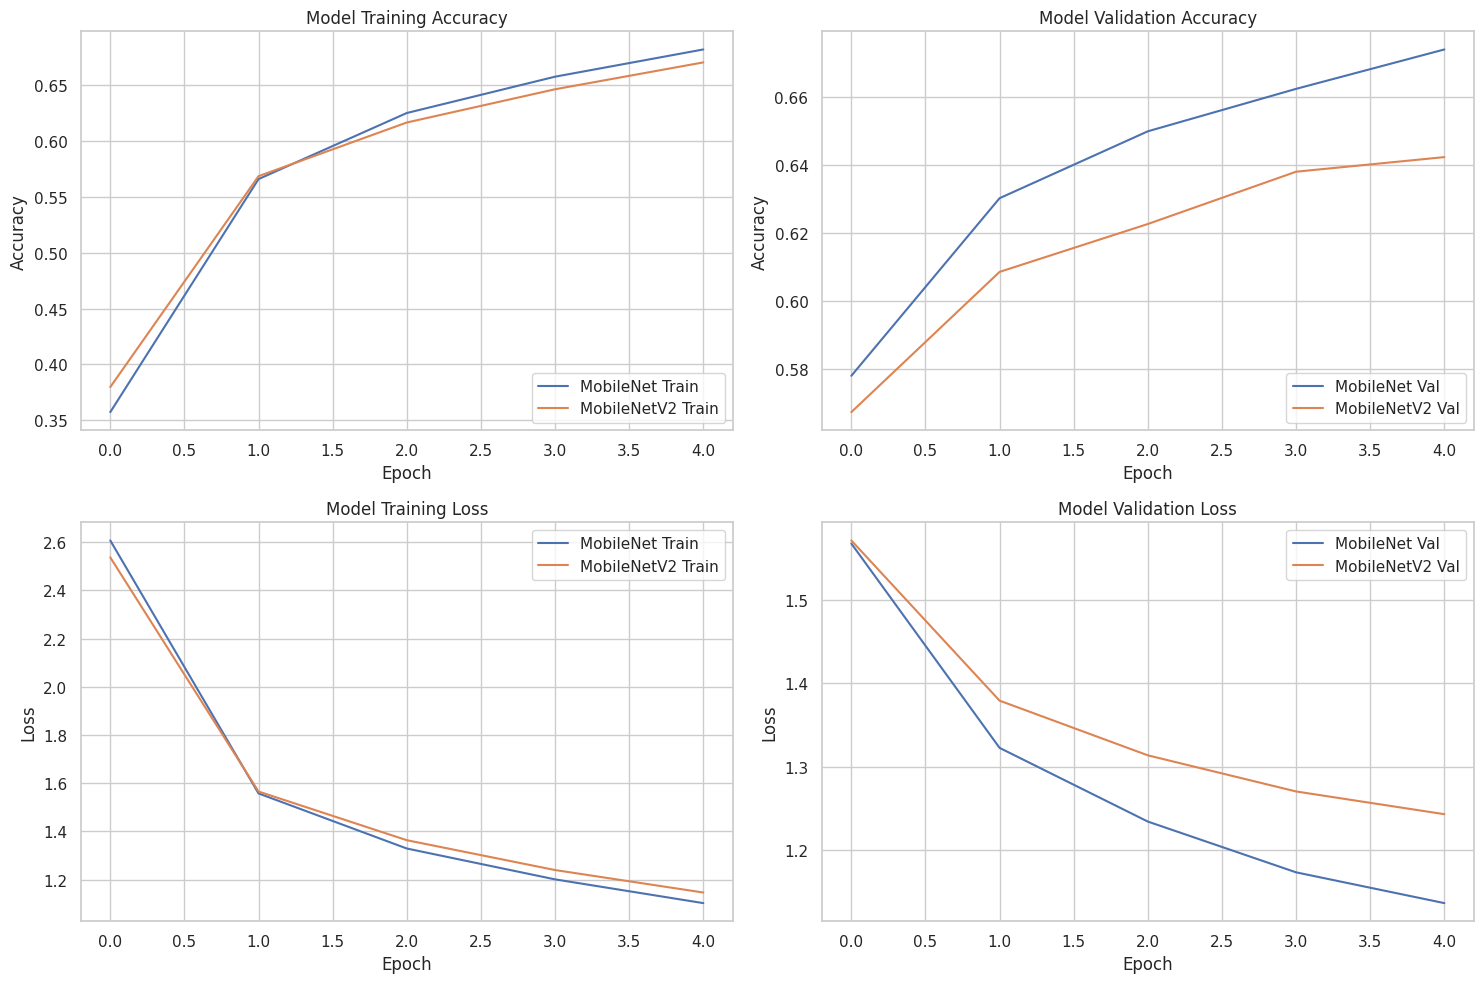

In [ ]:
# results = train_all_models(x_train, y_train, x_test, y_test)

# Train all models and get results + histories
results_df, histories = train_all_models(x_train, y_train, x_test, y_test)

# Plot the training histories
plot_training_histories(histories)